# Particle spray algorithm by Chen et al. (2025) via `gala`

Author: Yingtian "Bill" Chen

We provide a notebook to generate streams using the Chen+25 ([DOI:10.3847/1538-4365/ad9904](https://doi.org/10.3847/1538-4365/ad9904)) model via `gala`. This implementation has been merged to the main branch of `gala` since version `v1.9`.

## Import modules. Make sure they are properly installed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic

## Set up galactic potential and initial condition of the progenitor

Here, we use the `MWPotential2014` potential by Bovy (2015).

In [2]:
pot = gp.BovyMWPotential2014(units=galactic)
H = gp.Hamiltonian(pot)

prog_w0 = gd.PhaseSpacePosition(pos=[40, 0, 0] * u.kpc,
                                vel=[0, 100, 0] * u.km/u.s)
prog_mass = 1e5 * u.Msun

## Generate streams!

Here is the case of backward integration, which is more commonly used for stream modeling. But you can do forward integration by simply fliping the sign of `dt`.

In [3]:
# Fardal+15
df = ms.FardalStreamDF(gala_modified=False)
gen = ms.MockStreamGenerator(df, H)
%time stream_f15, prog_f15 = gen.run(prog_w0, prog_mass, dt=-6*u.Myr, n_steps=500)

# Chen+25 (no prog.)
df = ms.ChenStreamDF()
gen = ms.MockStreamGenerator(df, H)
%time stream_c25, prog_c25 = gen.run(prog_w0, prog_mass, dt=-6*u.Myr, n_steps=500)

# Chen+25 (with prog.)
df = ms.ChenStreamDF()
prog_pot = gp.PlummerPotential(m=prog_mass, b=4*u.pc, units=galactic)
gen = ms.MockStreamGenerator(df, H, progenitor_potential=prog_pot)
%time stream_c25b, prog_c25b = gen.run(prog_w0, prog_mass, dt=-6*u.Myr, n_steps=500)

CPU times: user 471 ms, sys: 7.91 ms, total: 479 ms
Wall time: 487 ms
CPU times: user 538 ms, sys: 4.55 ms, total: 542 ms
Wall time: 549 ms
CPU times: user 589 ms, sys: 5.44 ms, total: 594 ms
Wall time: 599 ms


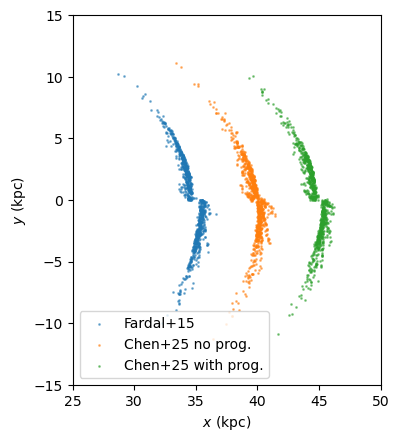

In [4]:
plt.scatter(stream_f15.pos.x.value-5, stream_f15.pos.y.value, s=1, alpha=0.5, label='Fardal+15')
plt.scatter(stream_c25.pos.x.value, stream_c25.pos.y.value, s=1, alpha=0.5, label='Chen+25 no prog.')
plt.scatter(stream_c25b.pos.x.value+5, stream_c25b.pos.y.value, s=1, alpha=0.5, label='Chen+25 with prog.')

plt.xlabel(r'$x\ ({\rm kpc})$')
plt.ylabel(r'$y\ ({\rm kpc})$')
plt.xlim(25, 50)
plt.ylim(-15, 15)
plt.legend(loc='lower left')
plt.gca().set_aspect(1)
plt.show()

## If you have agama installed, the following compares the action space distribution

In [5]:
import agama # to calculate action
agama.setUnits(length=1, velocity=1, mass=1) # working units: 1 Msun, 1 kpc, 1 km/s

actFinder = agama.ActionFinder(agama.Potential('data/MWPotential2014.ini'))

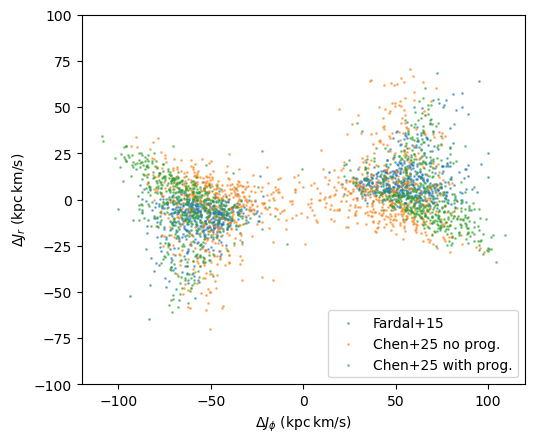

In [6]:
def get_action(stream, prog, actFinder):
    pos_prog = prog.pos.xyz.to('kpc').value
    vel_prog = prog.vel.d_xyz.to('km/s').value
    posvel_prog = np.r_[pos_prog.squeeze(),vel_prog.squeeze()]
    action_prog = actFinder(posvel_prog)
    Jphi_prog = action_prog[2]
    Jr_prog = action_prog[0]
    
    pos = stream.pos.xyz.to('kpc').value
    vel = stream.vel.d_xyz.to('km/s').value
    posvel = np.column_stack((pos.T,vel.T))
    actions = actFinder(posvel)
    Jphi = actions[:,2]
    Jr = actions[:,0]
    
    # DLtot = Ltot - Ltot_prog
    DJphi = Jphi - Jphi_prog
    DJr = Jr - Jr_prog
    return DJphi, DJr
    
DJphi, DJr = get_action(stream_f15, prog_f15, actFinder)
plt.scatter(DJphi, DJr, s=1, alpha=0.5, label='Fardal+15')

DJphi, DJr = get_action(stream_c25, prog_c25, actFinder)
plt.scatter(DJphi, DJr, s=1, alpha=0.5, label='Chen+25 no prog.')

DJphi, DJr = get_action(stream_c25b, prog_c25b, actFinder)
plt.scatter(DJphi, DJr, s=1, alpha=0.5, label='Chen+25 with prog.')

plt.xlabel(r'$\Delta J_\phi\ ({\rm kpc\,km/s})$')
plt.ylabel(r'$\Delta J_r\ ({\rm kpc\,km/s})$')
plt.xlim(-120, 120)
plt.ylim(-100, 100)
plt.legend(loc='lower right')
plt.gca().set_aspect(1)
plt.show()